In [4]:
import requests
import time
import os
import asyncio
import aiohttp
import nest_asyncio
import base64
import matplotlib.pyplot as plt
import threading
import numpy as np
import pandas as pd

lock = threading.Lock()
# Apply nest_asyncio to allow nested event loops in Jupyter Notebook
nest_asyncio.apply()
%matplotlib inline

# Define constants
MAX_CHUNK_SIZE = 512 * 1024 - 200
anton_base_url = "http://localhost:8021"
bob_base_url = "http://localhost:8031"
data_folder = "data"
DELAY_BETWEEN_GROUPS = 0  # Delay in seconds between sending groups of requests

# Helper function to handle responses
async def handle_response(response):
    response.raise_for_status()
    return await response.json()

async def read_and_encode_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            file_content = file.read()
        encoded_content = base64.b64encode(file_content).decode('utf-8')
        return encoded_content
    except Exception as e:
        print(f"Failed to read and encode file {file_path}: {e}")
        return None

def split_into_chunks(encoded_content, chunk_size):
    return [encoded_content[i:i + chunk_size] for i in range(0, len(encoded_content), chunk_size)]

async def send_didcomm_message_async(send_message_url, message, latency_list, timestamps, start_time, data_sent):
    try:
        url = send_message_url
        payload = message
        request_time = time.time()
        async with aiohttp.request("POST", url, json=payload, headers={"Content-Type": "application/json"}) as response:
            response_time = time.time()
            latency = response_time - request_time
            latency_list.append(latency)
            elapsed_time = response_time - start_time
            timestamps.append(elapsed_time)
            await handle_response(response)
            
            with lock:
                data_sent.append(len(message["attachments"][0]["data"]["base64"]))
    except aiohttp.ClientError as e:
        print(f"Failed to send message: {e}")

def calculate_average_metrics(timestamps, latency_list, data_sent):
    max_time = max(timestamps)
    num_intervals = 10
    interval = max_time / num_intervals

    averaged_timestamps = []
    averaged_latency = []
    averaged_throughput = []

    current_time = 0

    while current_time < max_time:
        next_time = current_time + interval
        interval_latencies = [lat for ts, lat in zip(timestamps, latency_list) if current_time <= ts < next_time]
        interval_data_sent = [ds for ts, ds in zip(timestamps, data_sent) if current_time <= ts < next_time]

        if interval_latencies:
            avg_latency = np.mean(interval_latencies)
        else:
            avg_latency = 0

        if interval_data_sent:
            total_data_sent = sum(interval_data_sent)
            throughput = total_data_sent / interval
        else:
            throughput = 0

        averaged_timestamps.append((current_time + next_time) / 2)
        averaged_latency.append(avg_latency)
        averaged_throughput.append(throughput)

        current_time = next_time

    return averaged_timestamps, averaged_latency, averaged_throughput

def plot_metrics(data, data_folder):
    timestamps = data['timestamps']
    latency_list = data['latency_list']
    data_sent = data['data_sent']

    # Ensure all lists are of the same length
    min_length = min(len(latency_list), len(data_sent), len(timestamps))
    latency_list = latency_list[:min_length]
    data_sent = data_sent[:min_length]
    timestamps = timestamps[:min_length]

    if min_length == 0:
        print(f"No data to plot for {data_folder}.")
        return

    # Calculate average metrics
    averaged_timestamps, averaged_latency, averaged_throughput = calculate_average_metrics(timestamps, latency_list, data_sent)

    # Print average metrics for debugging
    print(f"Averaged Timestamps for {data_folder}: {averaged_timestamps}")
    print(f"Averaged Latency for {data_folder}: {averaged_latency}")
    print(f"Averaged Throughput for {data_folder}: {averaged_throughput}")

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Latency (s)', color='tab:blue')
    ax1.plot(averaged_timestamps, averaged_latency, color='tab:blue', label='Latency', marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlim(left=0, right=max(timestamps))  # Set x-axis to start at 0 and end at max_time
    ax1.set_ylim(bottom=0)  # Set y-axis to start at 0 for latency

    ax2 = ax1.twinx()
    ax2.set_ylabel('Throughput (bytes/s)', color='tab:orange')
    ax2.plot(averaged_timestamps, averaged_throughput, color='tab:orange', label='Throughput', marker='x', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylim(bottom=0)  # Set y-axis to start at 0 for throughput

    fig.tight_layout()
    plt.title(f'Performance Metrics for {data_folder}')
    fig.legend(loc='upper left')

    plt.show()

async def test_performance(send_message_url, data_folder, parallel_count, num_repeats, route):
    latency_list = []
    data_sent = []
    timestamps = []

    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    encoded_files = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            encoded_content = await read_and_encode_file(file_path)
            if encoded_content:
                encoded_files.append((file_name, encoded_content))
                print(f"Encoded file: {file_name}, Size: {len(encoded_content)}")

    if not encoded_files:
        print("No files to encode and send.")
        return

    didcomm_message_template = {
        "type": "https://didcomm.org/file-transfer/1.0/message",
        "attachments": []
    }

    start_time = time.time()

    for _ in range(num_repeats):
        for file_name, encoded_content in encoded_files:
            chunks = split_into_chunks(encoded_content, MAX_CHUNK_SIZE)
            for idx, chunk in enumerate(chunks):
                tasks = []
                for _ in range(parallel_count):
                    didcomm_message = didcomm_message_template.copy()
                    didcomm_message["attachments"] = [
                        {
                            "filename": f"{file_name}.part{idx + 1}",
                            "data": {
                                "base64": chunk
                            }
                        }
                    ]
                    didcomm_message["content"] = f"Sending file {file_name} part {idx + 1}"
                    tasks.append(send_didcomm_message_async(send_message_url, didcomm_message, latency_list, timestamps, start_time, data_sent))
                await asyncio.gather(*tasks)
                await asyncio.sleep(DELAY_BETWEEN_GROUPS)  # Delay to average out the sending

    # Create a DataFrame and save it to a CSV file
    data = {
        'timestamps': timestamps,
        'latency_list': latency_list,
        'data_sent': data_sent
    }
    df = pd.DataFrame(data)
    df.to_csv(route, index=False)

    # Plot metrics
    plot_metrics(data, data_folder)

    # Debugging output
    print(f"Latency List for {data_folder}: {latency_list}")
    print(f"Data Sent List for {data_folder}: {data_sent}")
    print(f"Timestamps for {data_folder}: {timestamps}")


async def delete_connection(delete_url):
    async with aiohttp.request("DELETE", delete_url, headers={"Content-Type": "application/json"}) as response:
        status_code = response.status
        print(f"Deleted connection: {delete_url}")
        return status_code

async def fetch_connections(url):
    async with aiohttp.request("GET", url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)

async def create_request(url):
    async with aiohttp.request("POST", url, headers={"Accept": "application/json"}) as response:
        return await handle_response(response)    



Deleted connection: http://localhost:8021/connections/edc3b978-0dfe-49fa-ba59-a3f35b15f465
Deleted connection: http://localhost:8021/connections/a798a766-bd51-4c30-86a9-1b97cbdaa157
Encoded file: group.jpg, Size: 135104
Averaged Timestamps for data/picture: [2.3137141823768617, 6.941142547130585, 11.568570911884308, 16.195999276638034, 20.823427641391753, 25.45085600614548, 30.078284370899198, 34.705712735652924, 39.33314110040665, 43.960569465160376]
Averaged Latency for data/picture: [2.217433822154999, 3.6332576155662535, 2.162041407823563, 2.196285057067871, 2.149424874782562, 2.1630067110061644, 2.1634676575660707, 2.1507576167583466, 2.1476494669914246, 2.1982335408528644]
Averaged Throughput for data/picture: [1167853.8432193785, 583926.9216096892, 1167853.8432193785, 1167853.8432193785, 1167853.8432193785, 1167853.8432193785, 1167853.8432193785, 1167853.8432193785, 1167853.8432193785, 1751780.7648290677]


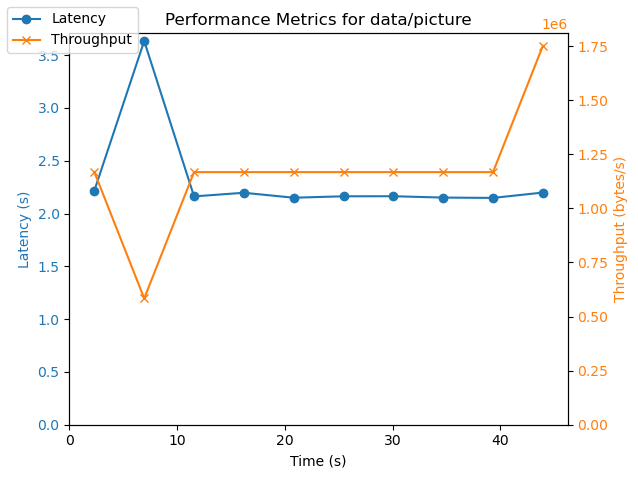

Latency List for data/picture: [2.2609026432037354, 2.2637851238250732, 2.262704610824585, 2.2682275772094727, 2.2657384872436523, 2.267253875732422, 2.2661654949188232, 2.273693799972534, 2.2748353481292725, 2.2854537963867188, 2.2793383598327637, 2.280348777770996, 2.276648998260498, 2.2853355407714844, 2.2777066230773926, 2.28164005279541, 2.2840960025787354, 2.284111976623535, 2.282362937927246, 2.2897143363952637, 2.1233487129211426, 2.130413055419922, 2.1348989009857178, 2.1463825702667236, 2.1471118927001953, 2.1451659202575684, 2.154658555984497, 2.1541528701782227, 2.1576650142669678, 2.1646528244018555, 2.1670050621032715, 2.1605422496795654, 2.1593260765075684, 2.169687509536743, 2.1683106422424316, 2.1761646270751953, 2.172206163406372, 2.179762840270996, 2.192383289337158, 2.1834497451782227, 3.5748491287231445, 3.5783727169036865, 3.5748491287231445, 3.579373598098755, 3.604088068008423, 3.6062734127044678, 3.6268391609191895, 3.6253154277801514, 3.6243138313293457, 3.629

In [5]:
async def main():
    try:
        # 1. Get Anton's connections and delete them
        anton_connections_url = f"{anton_base_url}/connections"
        anton_connections_response = await fetch_connections(anton_connections_url)
        anton_connections = anton_connections_response["results"]
        
        delete_tasks = []
        for connection in anton_connections:
            connection_id = connection["connection_id"]
            delete_url = f"{anton_base_url}/connections/{connection_id}"
            delete_tasks.append(delete_connection(delete_url))
        
        # Await all delete tasks
        await asyncio.gather(*delete_tasks)
    
        # 2. Get Bob's connections
        bob_connections_url = f"{bob_base_url}/connections"
        bob_connections_response = await fetch_connections(bob_connections_url)
    
        # 3. Bob sends a connection request to Anton
        bob_create_request_url = f"{bob_base_url}/didexchange/create-request?their_public_did=NyaE9SFSneSNRq6Ch8N9Pt&alias=Anton"
        bob_create_request_response = await create_request(bob_create_request_url)
        #bob_connection_id = bob_create_request_response["connection_id"]
    
        # Wait for the connection request to appear in Anton's connections
        await asyncio.sleep(2) 
    
        # 4. query again (if in different machines, ignore all step 1-3)
        anton_connections_url = f"{anton_base_url}/connections"
        anton_connections_response = await fetch_connections(anton_connections_url)
        anton_connections = anton_connections_response["results"]

        bob_connection_id = bob_connection_id = anton_connections[0]["connection_id"]

        # 5. Anton sends a message to Bob
        send_message_url = f"{anton_base_url}/connections/{bob_connection_id}/send-message"

        test_cases = [
            #('data/text', 50, 10, 'data/performance/test_text_http1_50_10_0ms.sh'),
            ('data/picture', 20, 20, 'data/performance/test_picture_http1_50_10_0ms.sh'),
            #('data/video', 20, 5, 'data/performance/test_video_http1_20_5_0ms.sh'),
        ]

        for data_folder, parallel_count, num_repeats, route in test_cases:
            await test_performance(send_message_url, data_folder, parallel_count, num_repeats, route)
    except KeyboardInterrupt:
        print("Process interrupted by user")

# Run the main function
try:
    asyncio.run(main())
except KeyboardInterrupt:
    print("Process interrupted by user")

